# Problem Statement

Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

# Importing libs

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam # - Works
import random
from glob import glob
import seaborn as sns
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import matplotlib.pyplot as plt
import matplotlib.image as img
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
try:
    tf.config.experimental.set_memory_growth = True
except Exception as ex:
    print(e)

[]


In [3]:
#mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:


#os.chdir("/content/gdrive/MyDrive")
#print(os.listdir())
#import zipfile
#with zipfile.ZipFile('CNN_assignment.zip', 'r') as zip_ref:
#   zip_ref.extractall('CNN_assignment_unzip')

# Reading input data

In [5]:
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/CNN_assignment_unzip/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path("/content/gdrive/MyDrive/CNN_assignment_unzip/Skin cancer ISIC The International Skin Imaging Collaboration/Test/")

In [6]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


# Prepare the dataset

In [7]:
batch_size = 32
img_height = 180
img_width = 180
rnd_seed = 123
random.seed(rnd_seed)

In [8]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [9]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [10]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  validation_split=0.9,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 118 files belonging to 9 classes.
Using 106 files for validation.


In [11]:
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


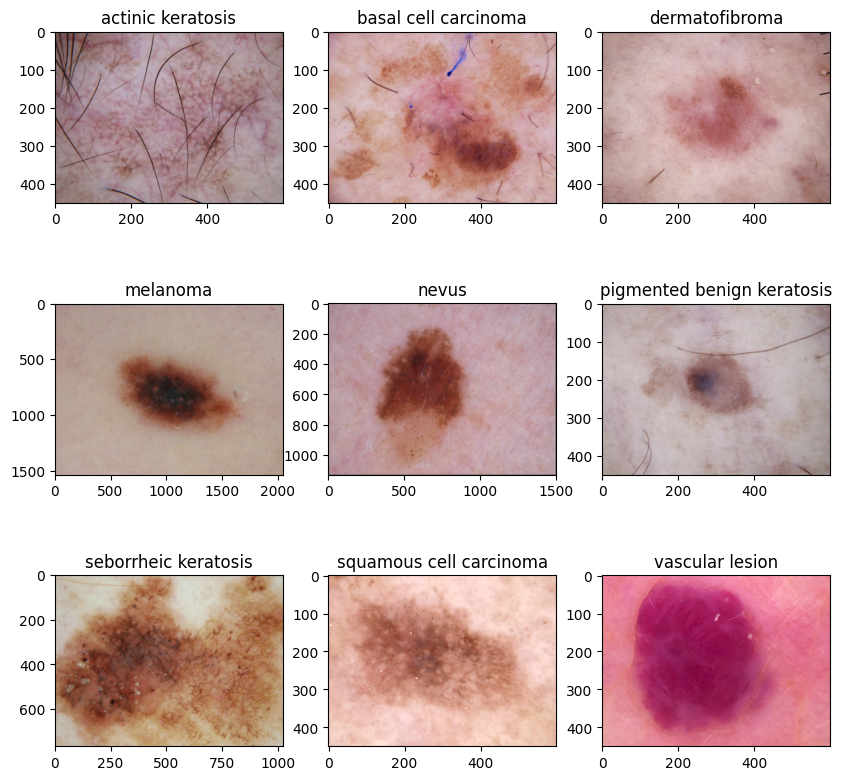

In [12]:
num_classes = len(class_names)
plt.figure(figsize=(10,10))
for i in range(num_classes):
  plt.subplot(3,3,i+1)
  image = img.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)


In [13]:
for image_batch, labels_batch in train_ds.take(1):
    print(image_batch.shape)
    print(labels_batch.shape)

(32, 180, 180, 3)
(32,)


In [14]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Model 1 : standard Model


In [15]:
num_classes = 9
model = Sequential([layers.experimental.preprocessing.Rescaling \
                    (1.0/255,input_shape=(img_height,img_width,3))])

model.add(Conv2D(32, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(64, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(128, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(256, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(512, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Flatten())
model.add(Dense(1024,activation="relu"))
model.add(Dense(units=num_classes, activation= 'softmax'))


In [16]:
opt = Adam(learning_rate=0.001)
model.compile(optimizer= opt,
              loss= SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 128)       7

In [18]:
epochs = 25
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/25
56/56 [==============================] - 456s 5s/step - loss: 2.0616 - accuracy: 0.2121 - val_loss: 1.9328 - val_accuracy: 0.2707
Epoch 2/25
56/56 [==============================] - 227s 4s/step - loss: 1.8686 - accuracy: 0.2997 - val_loss: 1.7868 - val_accuracy: 0.3647
Epoch 3/25
56/56 [==============================] - 223s 4s/step - loss: 1.6769 - accuracy: 0.3728 - val_loss: 1.6305 - val_accuracy: 0.4362
Epoch 4/25
56/56 [==============================] - 223s 4s/step - loss: 1.6040 - accuracy: 0.4314 - val_loss: 1.5067 - val_accuracy: 0.4609
Epoch 5/25
56/56 [==============================] - 221s 4s/step - loss: 1.5024 - accuracy: 0.4648 - val_loss: 1.5231 - val_accuracy: 0.4765
Epoch 6/25
56/56 [==============================] - 221s 4s/step - loss: 1.4359 - accuracy: 0.4950 - val_loss: 1.5668 - val_accuracy: 0.4899
Epoch 7/25
56/56 [==============================] - 218s 4s/step - loss: 1.3821 - accuracy: 0.5073 - val_loss: 1.4541 - val_accuracy: 0.4765
Epoch 8/25
56

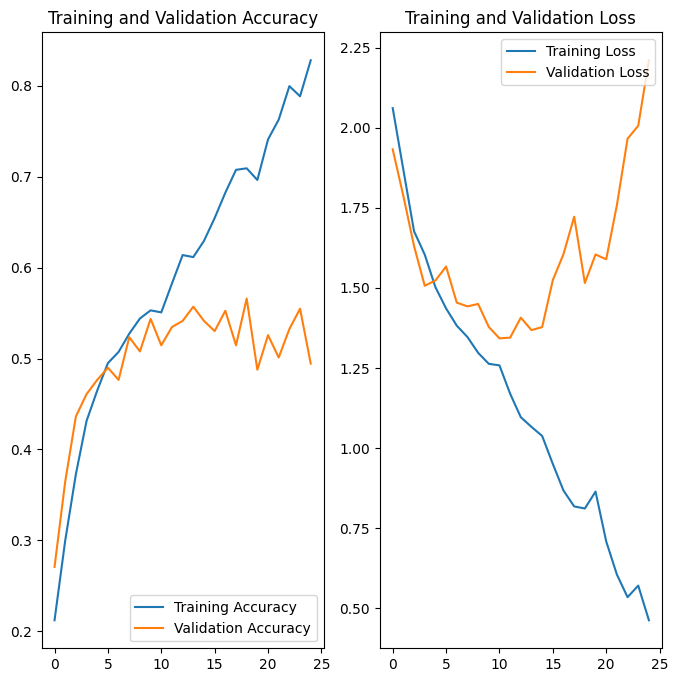

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Findings :
*    The model is exhibiting signs of overfitting as there is a significant difference in accuracy between the training data and validation data, with a gap of nearly 20%.

*   Despite training for 25 epochs, the model's accuracy on the training data is only around 70-75%, indicating that it still has room to learn additional features.

*   It is possible that the presence of data imbalance is introducing bias into the model's predictions.

# Model 2 : Data Augumentation with drop out layer.

In [20]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical",
                                                 input_shape=(img_height,
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
  ]
)


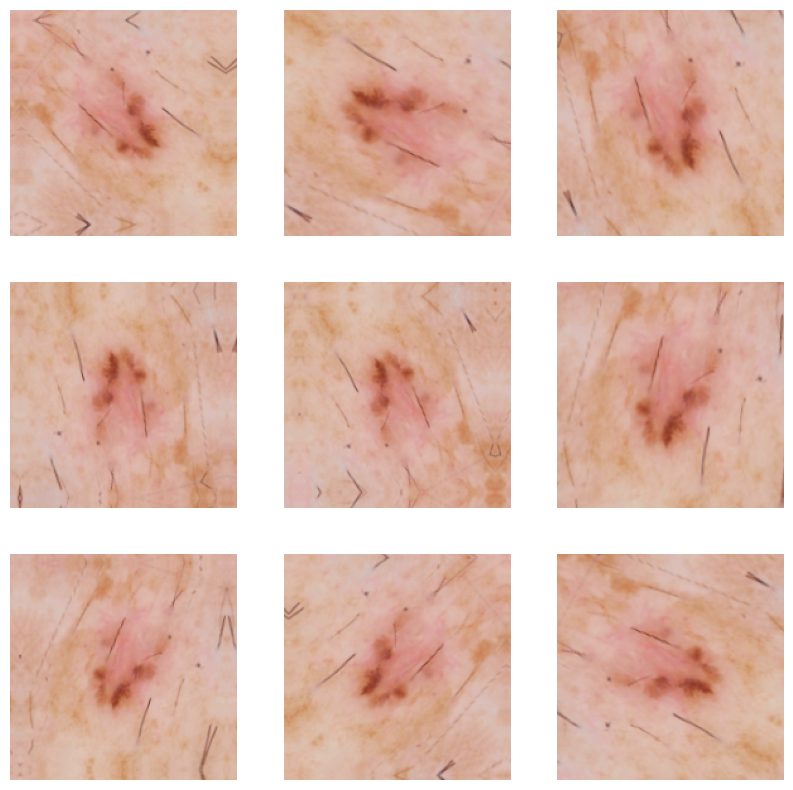

In [21]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")


In [22]:
num_classes = 9
model = Sequential(data_augmentation)
model.add(layers.experimental.preprocessing.Rescaling(1.0/255,input_shape=(img_height,img_width,3)))

model.add(Conv2D(32, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(64, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(128, 3,padding="same",activation='relu'))
model.add(MaxPool2D())
model.add(Dropout(0.15))

model.add(Conv2D(256, 3,padding="same",activation='relu'))
model.add(MaxPool2D())
model.add(Dropout(0.20))

model.add(Conv2D(512, 3,padding="same",activation='relu'))
model.add(MaxPool2D())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024,activation="relu"))
model.add(Dense(units=num_classes, activation= 'softmax'))


In [23]:
opt = Adam(lr=0.001)
model.compile(optimizer=opt,
              loss= SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [24]:
epochs = 25
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/25
56/56 [==============================] - 243s 4s/step - loss: 2.0763 - accuracy: 0.1925 - val_loss: 1.9312 - val_accuracy: 0.3043
Epoch 2/25
56/56 [==============================] - 240s 4s/step - loss: 1.8511 - accuracy: 0.2980 - val_loss: 1.7133 - val_accuracy: 0.3736
Epoch 3/25
56/56 [==============================] - 239s 4s/step - loss: 1.7122 - accuracy: 0.3655 - val_loss: 1.6382 - val_accuracy: 0.4004
Epoch 4/25
56/56 [==============================] - 233s 4s/step - loss: 1.5666 - accuracy: 0.4325 - val_loss: 1.6048 - val_accuracy: 0.4430
Epoch 5/25
56/56 [==============================] - 235s 4s/step - loss: 1.5017 - accuracy: 0.4777 - val_loss: 1.5572 - val_accuracy: 0.4743
Epoch 6/25
56/56 [==============================] - 233s 4s/step - loss: 1.4754 - accuracy: 0.4704 - val_loss: 1.5882 - val_accuracy: 0.4720
Epoch 7/25
56/56 [==============================] - 235s 4s/step - loss: 1.4931 - accuracy: 0.4777 - val_loss: 1.5033 - val_accuracy: 0.4922
Epoch 8/25
56

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Findings
* By implementing data augmentation techniques and incorporating drop layers, the overfitting issue of the model has been significantly mitigated. Previously, there was a substantial difference of nearly 20% between the accuracy of the training and validation data, but with the latest approach, this difference has been reduced to just 2-3%.

* However, it is worth noting that this improvement in addressing overfitting has come at the cost of a noticeable decrease in the overall accuracy of the model compared to the previous vanilla model.

* Taking these factors into consideration, there is still ample room for further improvement and refinement of the model.


# Analysing the class imbalance of the data

total training image count = 2239 

-------------------------------------
Class name =  actinic keratosis
count      =  114
proportion =  0.05091558731576597
-------------------------------------
Class name =  basal cell carcinoma
count      =  376
proportion =  0.16793211255024565
-------------------------------------
Class name =  dermatofibroma
count      =  95
proportion =  0.04242965609647164
-------------------------------------
Class name =  melanoma
count      =  438
proportion =  0.19562304600267977
-------------------------------------
Class name =  nevus
count      =  357
proportion =  0.15944618133095131
-------------------------------------
Class name =  pigmented benign keratosis
count      =  462
proportion =  0.20634211701652524
-------------------------------------
Class name =  seborrheic keratosis
count      =  77
proportion =  0.03439035283608754
-------------------------------------
Class name =  squamous cell carcinoma
count      =  181
proportion =  0.08083966056

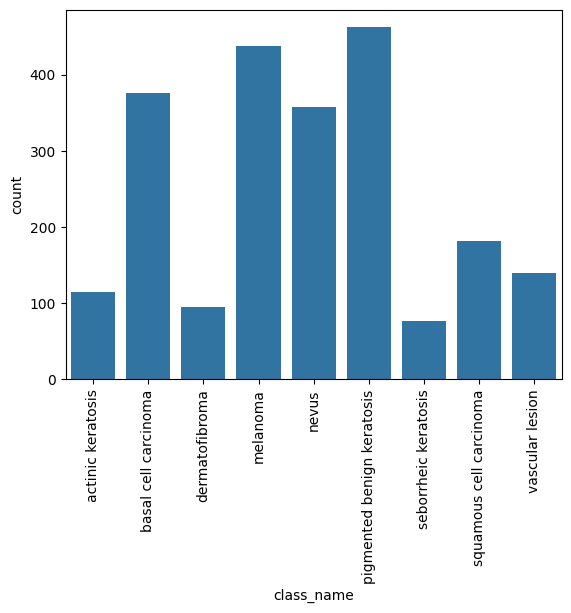

In [29]:
num_classes = len(class_names)
total = 0
all_count = []
class_name = []
for i in range(num_classes):
  count = len(list(data_dir_train.glob(class_names[i]+'/*.jpg')))
  total += count
print("total training image count = {} \n".format(total))
print("-------------------------------------")
for i in range(num_classes):
  count = len(list(data_dir_train.glob(class_names[i]+'/*.jpg')))
  print("Class name = ",class_names[i])
  print("count      = ",count)
  print("proportion = ",count/total)
  print("-------------------------------------")
  all_count.append(count)
  class_name.append(class_names[i])

temp_df = pd.DataFrame(list(zip(all_count, class_name)), columns = ['count', 'class_name'])
sns.barplot(data=temp_df, y="count", x="class_name")
plt.xticks(rotation=90)
plt.show()

## Findings
The heavy imbalance in the dataset can introduce bias in the results and predictions of the model.

# Augmentor : Class balance

Using Augmentor (https://augmentor.readthedocs.io/en/master/) to create the equal distribution of the class.

In [30]:
!pip install Augmentor

In [ ]:
path_to_training_dataset = '/content/gdrive/MyDrive/CNN_assignment_unzip/Skin cancer ISIC The International Skin Imaging Collaboration/Train/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i, output_directory='/working_data/'+i+'/output/')
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(1000)

Initialised with 114 image(s) found.
Output directory set to /working_data/actinic keratosis/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A8908C239A0>: 100%|██████████| 1000/1000 [00:38<00:00, 25.66 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /working_data/basal cell carcinoma/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A8919321DE0>: 100%|██████████| 1000/1000 [00:38<00:00, 26.00 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /working_data/dermatofibroma/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A8908EEFC70>: 100%|██████████| 1000/1000 [00:38<00:00, 26.09 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /working_data/melanoma/output/.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x7A89091AE590>:  18%|█▊        | 180/1000 [00:41<04:45,  2.87 Samples/s]  

In [ ]:
output_dir = pathlib.Path('/working_data/')
image_count_train = len(list(output_dir.glob('*/output/*.jpg')))
print(image_count_train)

In [ ]:
num_classes = len(class_names)
total = 0
all_count = []
class_name = []

for i in range(num_classes):
  count = len(list(output_dir.glob(class_names[i]+'/output/*.jpg')))
  total += count
print("total training image count = {} \n".format(total))
print("-------------------------------------")
for i in range(num_classes):
  count = len(list(output_dir.glob(class_names[i]+'/output/*.jpg')))
  print("Class name = ",class_names[i])
  print("count      = ",count)
  print("proportion = ",count/total)
  print("-------------------------------------")
  all_count.append(count)
  class_name.append(class_names[i])


temp_df = pd.DataFrame(list(zip(all_count, class_name)), columns = ['count', 'class_name'])
sns.barplot(data=temp_df, y="count", x="class_name")
plt.xticks(rotation=90)
plt.show()

# Model 3 : Model with Class balance data.

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  output_dir,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  output_dir,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)


In [ ]:
print(train_ds.class_names)

In [ ]:
num_classes = 9
model = Sequential([layers.experimental.preprocessing.Rescaling(1.0/255,input_shape=(img_height,img_width,3))])

model.add(Conv2D(32, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(64, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(128, 3,padding="same",activation='relu'))
model.add(MaxPool2D())
model.add(Dropout(0.15))

model.add(Conv2D(256, 3,padding="same",activation='relu'))
model.add(MaxPool2D())
model.add(Dropout(0.20))

model.add(Conv2D(512, 3,padding="same",activation='relu'))
model.add(MaxPool2D())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024,activation="relu"))
model.add(Dense(units=num_classes, activation= 'softmax'))


In [ ]:
opt = Adam(lr=0.001)
model.compile(optimizer= opt,
              loss = SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [ ]:
epochs = 25
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Findings :
* After rebalancing or resampling the data to ensure equal proportions, the accuracy of the model significantly improved to 90%. This effectively addressed the problem of low accuracy.

* Additionally, the issue of overfitting has been successfully resolved, as there is now only a small difference of approximately 4-5% between the accuracy of the training and validation sets.

* Considering these results, it can be concluded that the current model, trained on the rebalanced data, is the most optimal and effective one.


# Evaluation.

In [ ]:
#Create a file to save models
top_model_weights_path = '/kaggle/working/cnn_fc_model.h5'
model.save_weights(top_model_weights_path)


In [ ]:
(eval_loss, eval_accuracy) = model.evaluate(test_ds, batch_size=batch_size, \
                                            verbose=1)

In [ ]:
print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))
print("[INFO] Loss: {}".format(eval_loss))